In [142]:
from scholarNetwork import scholarNetwork

In [143]:
G=nx.DiGraph()
G.add_edge('source',1,weight=80)
G.add_edge(1,2,weight=50)
G.add_edge(1,3,weight=30)
G.add_edge(3,2,weight=10)
G.add_edge(2,4,weight=20)
G.add_edge(2,5,weight=30)
G.add_edge(4,5,weight=10)
G.add_edge(5,3,weight=5)
G.add_edge(2,'sink',weight=10)
G.add_edge(4,'sink',weight=10)
G.add_edge(3,'sink',weight=25)
G.add_edge(5,'sink',weight=35)

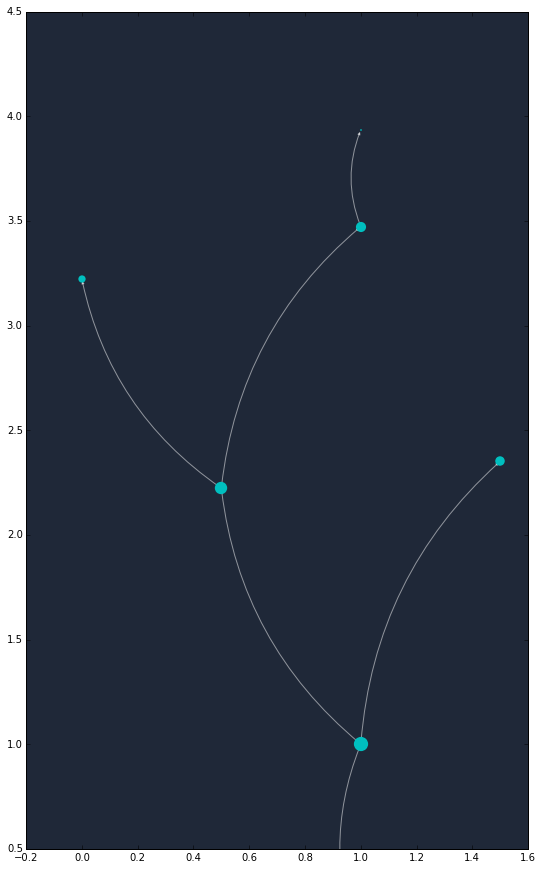

In [146]:
fig = plt.figure(figsize=(9, 15),facecolor='white')
ax = fig.add_subplot(111)
scholarNetwork.plotTree(G,ax)
plt.show()

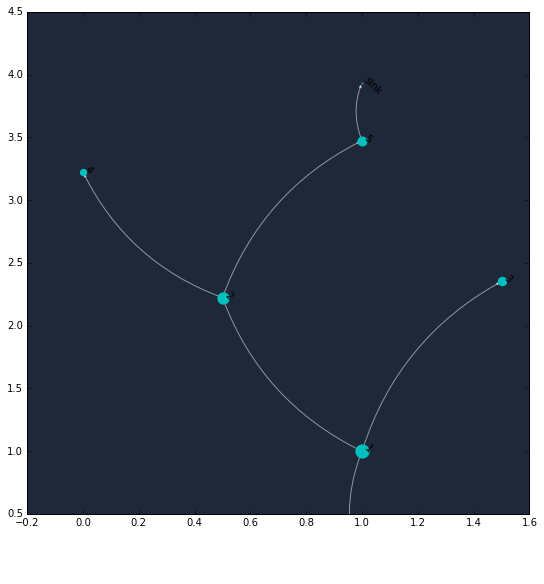

In [4]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scholarNetwork import scholarNetwork

G=nx.DiGraph()
G.add_edge('source',1,weight=80)
G.add_edge(1,2,weight=50)
G.add_edge(1,3,weight=30)
G.add_edge(3,2,weight=10)
G.add_edge(2,4,weight=20)
G.add_edge(2,5,weight=30)
G.add_edge(4,5,weight=10)
G.add_edge(5,3,weight=5)
G.add_edge(2,'sink',weight=10)
G.add_edge(4,'sink',weight=10)
G.add_edge(3,'sink',weight=25)
G.add_edge(5,'sink',weight=35)

fig = plt.figure(figsize=(9, 9),facecolor='white')
ax = fig.add_subplot(111)
scholarNetwork.plotTree(G,ax)
plt.show()

In [62]:
# -*- coding: utf-8 -*-
with open("/Users/chengjun/GitHub/scholarNetwork/scholarNetwork/edgelist.txt") as f:
    edges = f.readlines()

In [1]:
from collections import defaultdict
from collections import Counter
import matplotlib.pyplot as plt
import networkx as nx
from datetime import datetime as dt
import numpy as np
import matplotlib.cm as cm

In [2]:
class Tree:
    def __init__(self, node="", *children):
        self.node = node
        self.width = len(node)
        if children: self.children = children
        else:        self.children = []
    def __str__(self): 
        return "%s" % (self.node)
    def __repr__(self):
        return "%s" % (self.node)
    def __getitem__(self, key):
        if isinstance(key, int) or isinstance(key, slice): 
            return self.children[key]
        if isinstance(key, str):
            for child in self.children:
                if child.node == key: return child
    def __iter__(self): return self.children.__iter__()
    def __len__(self): return len(self.children)
    def addChild(self,nodeName): self.children.append(nodeName)

class DrawTree(object):
    def __init__(self, tree, parent=None, depth=0, number=1):
        self.x = -1.
        self.y = depth
        self.tree = tree
        self.children = [DrawTree(c, self, depth+1, i+1) 
                         for i, c
                         in enumerate(tree.children)]
        self.parent = parent
        self.thread = None
        self.mod = 0
        self.ancestor = self
        self.change = self.shift = 0
        self._lmost_sibling = None
        #this is the number of the node in its group of siblings 1..n
        self.number = number

    def left(self): 
        return self.thread or len(self.children) and self.children[0]

    def right(self):
        return self.thread or len(self.children) and self.children[-1]

    def lbrother(self):
        n = None
        if self.parent:
            for node in self.parent.children:
                if node == self: return n
                else:            n = node
        return n

    def get_lmost_sibling(self):
        if not self._lmost_sibling and self.parent and self != \
        self.parent.children[0]:
            self._lmost_sibling = self.parent.children[0]
        return self._lmost_sibling
    lmost_sibling = property(get_lmost_sibling)

    def __str__(self): return "%s: x=%s mod=%s" % (self.tree, self.x, self.mod)
    def __repr__(self): return self.__str__()        

def buchheim(tree):
    dt = firstwalk(DrawTree(tree))
    min = second_walk(dt)
    if min < 0:
        third_walk(dt, -min)
    return dt

def third_walk(tree, n):
    tree.x += n
    for c in tree.children:
        third_walk(c, n)

def firstwalk(v, distance=1.):
    if len(v.children) == 0:
        if v.lmost_sibling:
            v.x = v.lbrother().x + distance
        else:
            v.x = 0.
    else:
        default_ancestor = v.children[0]
        for w in v.children:
            firstwalk(w)
            default_ancestor = apportion(w, default_ancestor, distance)
        #print "finished v =", v.tree, "children"
        execute_shifts(v)

        midpoint = (v.children[0].x + v.children[-1].x) / 2

        ell = v.children[0]
        arr = v.children[-1]
        w = v.lbrother()
        if w:
            v.x = w.x + distance
            v.mod = v.x - midpoint
        else:
            v.x = midpoint
    return v

def apportion(v, default_ancestor, distance):
    w = v.lbrother()
    if w is not None:
        #in buchheim notation:
        #i == inner; o == outer; r == right; l == left; r = +; l = -
        vir = vor = v
        vil = w
        vol = v.lmost_sibling
        sir = sor = v.mod
        sil = vil.mod
        sol = vol.mod
        while vil.right() and vir.left():
            vil = vil.right()
            vir = vir.left()
            vol = vol.left()
            vor = vor.right()
            vor.ancestor = v
            shift = (vil.x + sil) - (vir.x + sir) + distance
            if shift > 0:
                move_subtree(ancestor(vil, v, default_ancestor), v, shift)
                sir = sir + shift
                sor = sor + shift
            sil += vil.mod
            sir += vir.mod
            sol += vol.mod
            sor += vor.mod
        if vil.right() and not vor.right():
            vor.thread = vil.right()
            vor.mod += sil - sor
        else:
            if vir.left() and not vol.left():
                vol.thread = vir.left()
                vol.mod += sir - sol
            default_ancestor = v
    return default_ancestor

def move_subtree(wl, wr, shift):
    subtrees = wr.number - wl.number
    #print wl.tree, "is conflicted with", wr.tree, 'moving', subtrees, 'shift', shift
    #print wl, wr, wr.number, wl.number, shift, subtrees, shift/subtrees
    wr.change -= shift / subtrees
    wr.shift += shift
    wl.change += shift / subtrees
    wr.x += shift
    wr.mod += shift

def execute_shifts(v):
    shift = change = 0
    for w in v.children[::-1]:
        #print "shift:", w, shift, w.change
        w.x += shift
        w.mod += shift
        change += w.change
        shift += w.shift + change

def ancestor(vil, v, default_ancestor):
    #the relevant text is at the bottom of page 7 of
    #"Improving Walker's Algorithm to Run in Linear Time" by Buchheim et al, (2002)
    #http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.16.8757&rep=rep1&type=pdf
    if vil.ancestor in v.parent.children:
        return vil.ancestor
    else:
        return default_ancestor

def second_walk(v, m=0, depth=0, min=None):
    v.x += m
    v.y = depth
    if min is None or v.x < min:
        min = v.x
    for w in v.children:
        min = second_walk(w, m + v.mod, depth+1, min)
    return min

def generateTree(edgeDic):
    allNodes={}
    for k,v in edgeDic.items():
        if k in allNodes:
            n=allNodes[k]
        else:
            n=Tree(k,)
            allNodes[k]=n
        for s in v:
            if s in allNodes:
                cn=allNodes[s]
            else:
                cn=Tree(s,)
                allNodes[s]=cn
            allNodes[k].addChild(cn)
    return allNodes

In [9]:
edges={'root':['bigleft','m1','m2','m3','m4','bigright'],
       'brr':['br1','br2','br3','br4','br5','br6','br7'],
         'bigleft':['l1','l2','l3','l4','l5','l6','l7'],
         'l7':['ll1'],
         'm3':['m31'],
         'bigright':['brr']
         }

treeDic = generateTree(edges)
tree = treeDic['root']
d = buchheim(tree)

In [10]:
def drawt(root,circle):
    plt.scatter(root.x, root.y, facecolor='gray',lw = 0,s=100,alpha=.3)
    plt.text(root.x, root.y,root.tree,fontsize=10)
    for child in root.children:
        drawt(child,circle)

def drawconn(root,circle):
    for child in root.children: 
        plt.plot([root.x, child.x],[root.y,child.y],linestyle='-',linewidth=1,color='grey',alpha=0.7)
        drawconn(child,circle)

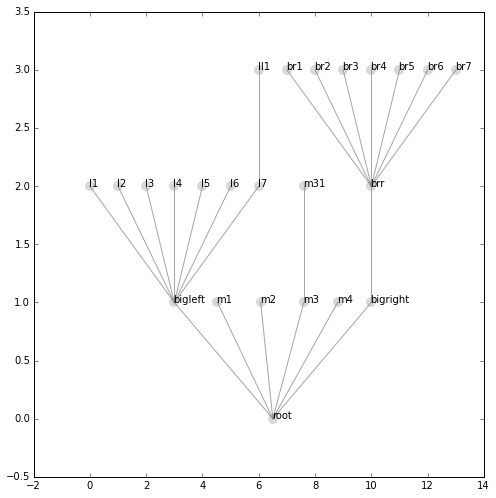

In [11]:
fig = plt.figure(figsize=(7,7),facecolor='white')
#
ax1 = fig.add_subplot(111)
drawt(d,False)
drawconn(d,False)

plt.tight_layout()
plt.show()

In [12]:
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

G = nx.DiGraph()
for m in edges: #for network plot
    G.add_edge(m.split('\t')[0].decode('utf-8'), m.split('\t')[1].decode('utf-8'), weight = 1)
    
    
    
    
pos=nx.spring_layout(G) #设置网络的布局
fig = plt.figure(figsize=(40, 40),facecolor='white')
nx.draw(G, pos, node_shape = 'o',
        edge_color = 'gray', width = 0.5,
        with_labels = True, arrows = True)
plt.show()

IndexError: list index out of range

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Sun Feb 22 14:19:41 2015

@author: chengjun
"""

import urllib2
from bs4 import BeautifulSoup
from collections import defaultdict
import networkx as nx



def getGraph(seed, Nmax):
    urls = defaultdict(int)
    urls[seed]+=1
    newUrls = [seed]# initiate the coauthor list
    G = nx.DiGraph()
    def coAuthors(url): 
        coUrls = []
        coNames = [] #for network plot
        html = urllib2.urlopen(url).read()
        soup = BeautifulSoup(html)
        s = soup.body.findAll('a', {"class": "gsc_rsb_aa"})
        egoName = soup.body.find('div', {"id": "gsc_prf_in"}).text #for network plot
        if s:
            for i in s:
                coNames.append(i.text) #for network plot
                coUrls.append('http://scholar.google.nl'+ i['href'])
        for j in coUrls:
            urls[j] += 0 
        for m in coNames: #for network plot
            G.add_edge(egoName.split(',')[0], m.split(',')[0])
        return coUrls
    
    while newUrls:
        for k in urls.keys(): # update url.values() first
            urls[k] += 1 
        addUrls = [] # get new-added authors, may have duplications.
        for i in newUrls:
            coUrls = coAuthors(i)
            if coUrls:
                for j in coUrls:
                    addUrls.append(j)
        for m in set(addUrls): # get rid of the duplications
            urls[m] += 1
        newUrls = [k for k, v in urls.items() if v <= 1]# update the new coauthors and avoid the deadloop: a->b->a->......
        addUrls = []   
        print len(urls.keys())
        if len(urls.keys()) > Nmax:
            print 'more than '+str(Nmax)+' people now, break'
            break
    return G

    
### plot local network
#import matplotlib.pyplot as plt
#seed = 'https://scholar.google.nl/citations?user=nNdt_G8AAAAJ&hl=en&oe=ASCII'
#Nmax = 500
#g = getGraph(seed, Nmax)
#pos=nx.spring_layout(G) #设置网络的布局
#fig = plt.figure(figsize=(40, 40),facecolor='white')
#nx.draw(G, pos, node_shape = 'o',
#        edge_color = 'gray', width = 0.5,
#        with_labels = True, arrows = True)
#plt.show()

In [104]:
def coAuthors(url): 
    coUrls = []
    html = urllib2.urlopen(url).read()
    soup = BeautifulSoup(html)
    s = soup.body.findAll('a', {"class": "gsc_rsb_aa"})
    if s:
        for i in s:
            coUrls.append('http://scholar.google.nl'+ i['href'])
    return coUrls

In [ ]:
def getTree(seed, Nstep=4):
    n=1
    tree={}
    tree[seed]=coAuthors(seed)
    while n<= Nstep:
        n+=1
        for root in tree:
            for child in tree[root]:
                if child not in tree:
                    tree[child]=coAuthors(child)
    return tree

In [108]:
import json
dat = json.load(open('/Users/chengjun/GitHub/scholarNetwork/scholarNetwork/namedict.dat'), encoding='utf-8')

In [138]:
tree.children

[bigleft, m1, m2, m3, m4, bigright]

In [122]:
tree={}
for k,v in dat.items():
    k=k.encode('ascii',errors='ignore')
    v=[i.encode('ascii',errors='ignore') for i in v]
    tree[k]=v

In [124]:
treeDic = generateTree(tree)

In [127]:
t=treeDic[u'chengjun']

In [140]:
for i in t.children:
    print i,i.children

Jonathan J. H. Zhu, Jian-Hua Zhu, ... [Tai-Quan Peng , Lars Willnat, Xiaoming Li, Shixia Liu, Yingcai Wu, Panpan Xu, Jie Qin, Cheng-Jun Wang, Guanrong Chen, Fei Chen, Zhenzhen Wang, 'Chris' Fei Shen , /Yiqun LIU]
Tai-Quan Peng  [Jonathan J. H. Zhu, Jian-Hua Zhu, ..., Yingcai Wu, Shixia Liu, Panpan Xu, Zhenzhen Wang, 'Chris' Fei Shen , Hai Liang , Crystal Li Jiang ]
Marco Janssen [Elinor Ostrom, John Anderies, Wander Jager, Brian Walker, Allen Lee, Pieter van Beukering, Michael Schoon, francois bousquet, Garry D. Peterson, Amy R. Poteete, Juan Camilo Cardenas, Jeroen C.J.M. van den Bergh, Steven M. Manson, Peter Deadman, Frans Berkhout, Stephen Carpenter, Louis Lebel, Jon Norberg, Graeme Cumming, Michel den Elzen]
lingfei wu [Jiang Zhang, Marco Janssen, Jacopo Baggio, Cheng-Jun Wang]


In [128]:
d = buchheim(t)

RuntimeError: maximum recursion depth exceeded